In [15]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [16]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [17]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [18]:
class_names = dataset.class_names
class_names #Basically, your folder names are basically your class names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [19]:
len(dataset)

68

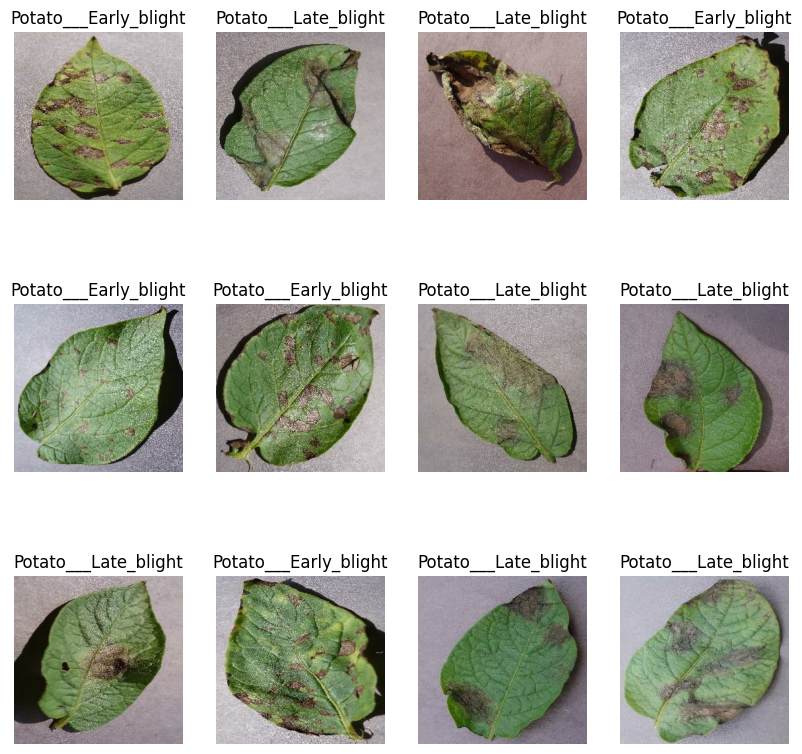

In [20]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
     for i in range(12):
         ax = plt.subplot(3,4, i+1)
         plt.imshow(image_batch[i].numpy().astype("uint8"))
         plt.title(class_names[label_batch[i]])
         plt.axis("off")
         
     

In [ ]:
80% ==> training
20% ==> 10% validation, 10% test

In [21]:
train_size = 0.8
len(dataset)*train_size 

54.400000000000006

In [31]:
train_ds = dataset.take(54)
len(train_ds)

54

In [32]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [33]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [34]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [35]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [36]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds.skip(train_size).take(val_size)
    test_ds.skip(train_size).skip(val_size)
    

    return train_ds, val_ds, test_ds

In [37]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [38]:
len(train_ds)

54

In [39]:
len(val_ds)

6

In [40]:
len(test_ds)

8

In [44]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [47]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

<Sequential name=sequential, built=False>

In [51]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal and vertical"),
    layers.RandomRotation(0.2)
])